# Exploring Different Fitness / Selection Criterion

Goal 1: Implement surviving parents alongside reproducing population. Up until now, we have been selecting genes at random from the best 50% of the population. So the next generation was all children with an amalgam of genes from the parent generation. Now we will implement survivors. These are solutions in our population who not only have the opportunity to reproduce, but they will survive intact to the next generation. This will be a small subsample of the best of the best in out population maybe the top 10%. 

Goal 2: Test different ratios for the reproducing population and carryover population. Default is use the best 50% to reproduce and 10% to survive, what do other ratios look like? Which one works best/should we use for our model? How does this affect diversity vs accuracy?

Goal 3: Implement the "low-ranking chimp." In hierarchical chimpanzee society, it is mainly the "Alpha" males who mate with the females of the group. However, the lower ranking males do, on occasion reproduce too. I think it would be interesting to see if implementing a low probability chance that one or several of the lowest ranking individuals pass on their genes would affect the model. I predict that it will be some sort of 

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../ExplorationVsExploitation')  # Replace '/path/to/EVO_BASE' with the actual path to the module
from EVO import LogisticRegression, EvolutionOptimizer
from fitness import FitnessOptimizer
import torch
import numpy as np
import time
import random
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

In [17]:
def accuracy(model, X, y):
    device = model.w.device if model.w is not None else torch.device("cpu")
    X, y = X.to(device), y.to(device)
    y_pred = model.predict(X)
    return (y_pred == y).float().mean().item()


Training on cuda
Accuracy: 0.7699999809265137 Loss: -2.509927988052368
Accuracy: 0.7400000095367432 Loss: -2.5718255043029785
Accuracy: 0.75 Loss: -2.586402416229248
Accuracy: 0.7299999594688416 Loss: -2.6497979164123535
Accuracy: 0.7999999523162842 Loss: -2.73331356048584
Accuracy: 0.8199999928474426 Loss: -2.7622013092041016
Accuracy: 0.8499999642372131 Loss: -2.8272125720977783
Accuracy: 0.85999995470047 Loss: -2.891157627105713
Accuracy: 0.9099999666213989 Loss: -2.9308574199676514
Accuracy: 0.8999999761581421 Loss: -2.963050127029419
Accuracy: 0.8999999761581421 Loss: -3.0172085762023926
Accuracy: 0.9099999666213989 Loss: -3.1210684776306152
Accuracy: 0.9300000071525574 Loss: -3.153181791305542
Accuracy: 0.9399999976158142 Loss: -3.1626455783843994
Accuracy: 0.9799999594688416 Loss: -3.1799328327178955
Accuracy: 0.9699999690055847 Loss: -3.192379951477051
Accuracy: 0.9699999690055847 Loss: -3.2499589920043945
Accuracy: 0.9799999594688416 Loss: -3.290923595428467
Accuracy: 0.989999

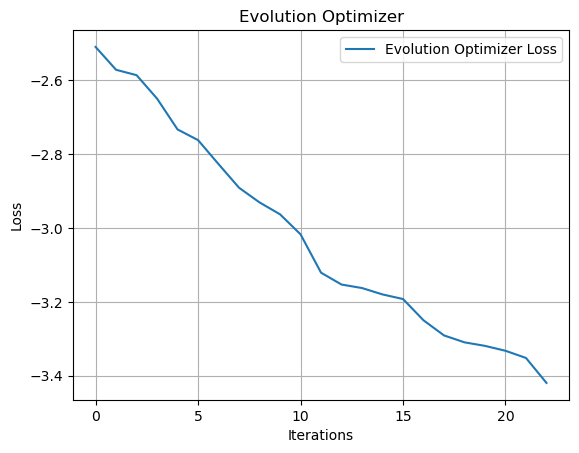

In [18]:
X, y = classification_data(p_dims=200, noise=0.2, n_points=100)
LR = LogisticRegression()
opt = FitnessOptimizer(LR)
opt.set_mutation_rate(0.5)
opt.set_population_size(100)

print(f'Training on {opt.device}')

LR.set_optimizer(opt)

device = opt.device
X, y = X.to(device), y.to(device)

loss = []
epoch = 1
start = time.time()
while accuracy(LR, X, y) < 1:
    opt.step(X, y, fitness_threshold=2)
    loss.append(LR.loss(X, y).item())
    print(f"Epoch {epoch}\n    Accuracy: {accuracy(LR, X, y)}\n    Loss: {loss[-1]}")


print("Time taken: ", time.time() - start)
plt.plot(loss, label="Evolution Optimizer Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Evolution Optimizer")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
thresh_range = range(2, 10)
loss_dict = {}

for thresh in thresh_range:
    print(f"Running for thresh = {thresh}")
    
    # Generate new data for fairness (or keep it fixed if you prefer)
    X, y = classification_data(p_dims=200, noise=0.8, n_points=100)
    
    # Set up model and optimizer
    LR = LogisticRegression()
    opt = FitnessOptimizer(LR)
    LR.set_optimizer(opt)
    opt.set_population_size(100)
    opt.set_diversity_coeff(0)
    
    # Loss tracking
    loss = []
    start = time.time()
    
    # Optimization loop
    while accuracy(LR, X, y) < 1:
        opt.step(X, y, fitness_threshold=thresh)
        loss.append(LR.loss(X, y).item())
    
    print(f"Finished in {len(loss)} iterations, Time: {round(time.time() - start, 2)}s")
    loss_dict[thresh] = loss

# Plotting
plt.figure(figsize=(12, 8))
for k, loss in loss_dict.items():
    plt.plot(loss, label=f"Best 1/{k}")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Evolution Optimizer Loss vs Survival Ratio")
plt.legend(title="Thresholds")
plt.grid(True)
plt.show()


Running for thresh = 2


KeyboardInterrupt: 